# Training Imitation Learning Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

## Check if TensorFlow is Detecting GPU

In [2]:
# Check if TensorFlow can access GPU devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("Found GPU device(s):")
    for device in gpu_devices:
        print(device)
else:
    print("No GPU devices found. TensorFlow will use CPU.")

print("TensorFlow GPU options and configurations:")
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.config.experimental.get_visible_devices('GPU'))
print(tf.config.experimental.get_memory_growth(gpu_devices[0]))  # Assuming there is at least one GPU device

Found GPU device(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow GPU options and configurations:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None


2024-04-08 15:59:50.364260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 15:59:50.367551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 15:59:50.367673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Define the Default Path

In [3]:
# Define root directories and CSV paths
root_dirs = {
    'asphalt': ('data_asphalt/', 'data_asphalt/data.csv'),
    'desert': ('data_desert/', 'data_desert/data.csv'),
    'offroad': ('data_offroad/', 'data_offroad/data.csv'),
}

## Remove Stationary Images from Dataset

In [57]:
def clean_dataset(root_dir, csv_path):
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Identify rows where linear.x is 0
    zero_linear_x = df[df['linear_x'] == 0]
    
    # Remove these rows from the dataframe
    df_cleaned = df[df['linear_x'] != 0]
    
    # Overwrite the cleaned dataframe to the current CSV
    df_cleaned.to_csv(csv_path, index=False)
    
    # Remove corresponding images from the folder
    for image_name in zero_linear_x['image_name']:
        image_path = os.path.join(root_dir, image_name)
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f'Removed: {image_path}')
        else:
            print(f'File not found: {image_path}')

### Asphalt

In [60]:
# Clean the asphalt dataset
root_dir_asphalt, csv_path_asphalt = root_dirs['asphalt']
print(f"Cleaning dataset for asphalt environment.")
clean_dataset(root_dir_asphalt, csv_path_asphalt)

Cleaning dataset for asphalt environment.


### Desert

In [ ]:
# Clean the desert dataset
root_dir_desert, csv_path_desert = root_dirs['desert']
print(f"Cleaning dataset for desert environment.")
clean_dataset(root_dir_desert, csv_path_desert)

### Offroad

In [ ]:
# Clean the offroad dataset
root_dir_offroad, csv_path_offroad = root_dirs['offroad']
print(f"Cleaning dataset for offroad environment.")
clean_dataset(root_dir_offroad, csv_path_offroad)

## Create Training Dataset

In [6]:
def load_and_preprocess_data(csv_path, root_dir):
    data = pd.read_csv(csv_path)
    images = []
    angular_zs = []

    for _, row in data.iterrows():
        img_path = os.path.join(root_dir, row['image_name'])
        image = np.array(Image.open(img_path))
        images.append(image)
        angular_zs.append(row['angular_z'])

    # Convert lists to numpy arrays and normalize images
    images = np.array(images).astype('float32') / 255.0
    angular_zs = np.array(angular_zs)

    return images, angular_zs

### Asphalt

In [61]:
# Load and preprocess data for the asphalt environment
root_dir_asphalt, csv_path_asphalt = root_dirs['asphalt']
images_asphalt, angular_zs_asphalt = load_and_preprocess_data(csv_path_asphalt, root_dir_asphalt)

### Desert

In [ ]:
# Load and preprocess data for the desert environment
root_dir_desert, csv_path_desert = root_dirs['desert']
images_desert, angular_zs_desert = load_and_preprocess_data(csv_path_desert, root_dir_desert)

### Offroad

In [ ]:
# Load and preprocess data for the offroad environment
root_dir_offroad, csv_path_offroad = root_dirs['offroad']
images_offroad, angular_zs_offroad = load_and_preprocess_data(csv_path_offroad, root_dir_offroad)

## Shuffle and Unpack Dataset

In [8]:
def shuffle_and_unpack_data(images, angular_zs):
    """
    Shuffles and unpacks images and their corresponding labels (angular_zs).
    
    Parameters:
    - images: numpy array of images.
    - angular_zs: numpy array of angular_z values.
    
    Returns:
    - shuffled_images: numpy array of shuffled images.
    - shuffled_angular_zs: numpy array of shuffled angular_z values.
    """
    # Pair up images and labels
    img_label_set = list(zip(images, angular_zs))
    
    # Shuffle the paired dataset
    np.random.shuffle(img_label_set)
    
    # Unpack the shuffled dataset back into images and labels
    shuffled_images, shuffled_angular_zs = zip(*img_label_set)
    
    # Convert them back to numpy arrays
    shuffled_images = np.array(shuffled_images)
    shuffled_angular_zs = np.array(shuffled_angular_zs)
    
    return shuffled_images, shuffled_angular_zs

### Asphalt

In [62]:
# Shuffle and unpack for the asphalt environment
images_asphalt, angular_zs_asphalt = shuffle_and_unpack_data(images_asphalt, angular_zs_asphalt)

### Desert

In [ ]:
# Shuffle and unpack for the desert environment
images_desert, angular_zs_desert = shuffle_and_unpack_data(images_desert, angular_zs_desert)

### Offroad

In [ ]:
# Shuffle and unpack for the offroad environment
images_offroad, angular_zs_offroad = shuffle_and_unpack_data(images_offroad, angular_zs_offroad)

## Define CNN Architecture

In [51]:
def create_cnn(input_shape):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 4
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Dense Layer 1 with Dropout
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Dense Layer 2 with Dropout
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer with one neuron since it's a regression problem
    model.add(layers.Dense(1))

    return model

In [ ]:
def create_cnn(input_shape):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Removed Convolutional Layer 3 and 4 for simplification

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Dense Layer 1 with Dropout
    model.add(layers.Dense(256, activation='relu'))  # Reduced number of units
    model.add(layers.Dropout(0.4))  # Adjusted dropout rate

    # Removed Dense Layer 2 for simplification

    # Output Layer with one neuron since it's a regression problem
    model.add(layers.Dense(1))

    return model

In [63]:
def create_cnn(input_shape):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2 (Adjusted filters)
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Reintroduced Convolutional Layer 3 (Reduced filters)
    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu'))  # Adjusted number of filters
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Dense Layer 1 with Dropout (Adjusted units and dropout)
    model.add(layers.Dense(256, activation='relu'))  # Adjusted number of units
    model.add(layers.Dropout(0.4))  # Fine-tuned dropout rate

    # Output Layer
    model.add(layers.Dense(1))

    return model

## Compile and Train the Model

### Asphalt

In [64]:
# Create the CNN model
input_shape_asphalt = images_asphalt.shape[1:]  # Get the input shape from the asphalt dataset
cnn_asphalt = create_cnn(input_shape_asphalt)

# Compile the model
cnn_asphalt.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_asphalt = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_asphalt = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-7)

In [65]:
# Visualize the model
cnn_asphalt.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 44, 128, 32)       2432      
                                                                 
 batch_normalization_23 (Bat  (None, 44, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 22, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 22, 64, 64)        18496     
                                                                 
 batch_normalization_24 (Bat  (None, 22, 64, 64)       256       
 chNormalization)                                                
                                                      

### Desert

In [ ]:
# Create the CNN model
input_shape_desert = images_desert.shape[1:]  # Get the input shape from the asphalt dataset
cnn_desert = create_cnn(input_shape_desert)

# Compile the model
cnn_desert.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_desert = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_desert = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-7)

In [ ]:
# Visualize the model
cnn_desert.summary()

### Offroad

In [ ]:
# Create the CNN model
input_shape_offroad = images_offroad.shape[1:]  # Get the input shape from the asphalt dataset
cnn_offroad = create_cnn(input_shape_offroad)

# Compile the model
cnn_offroad.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Early stopping callback to stop training when the validation loss has stopped improving
early_stopping_offroad = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr_offroad = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-7)

In [ ]:
# Visualize the model
cnn_offroad.summary()

## Train the Model

### Asphalt

In [66]:
history_asphalt = cnn_asphalt.fit(
    images_asphalt, 
    angular_zs_asphalt, 
    validation_split=0.20, 
    epochs=200, 
    batch_size=16, 
    callbacks=[early_stopping_asphalt, reduce_lr_asphalt]
)

Epoch 1/200
297/297 [==============================] - 2s 5ms/step - loss: 21.9176 - accuracy: 0.5495 - val_loss: 1.0141 - val_accuracy: 0.4405 - lr: 0.0010
Epoch 2/200
297/297 [==============================] - 1s 4ms/step - loss: 0.3532 - accuracy: 0.5953 - val_loss: 0.3493 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 3/200
297/297 [==============================] - 1s 4ms/step - loss: 0.3062 - accuracy: 0.6126 - val_loss: 0.2729 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 4/200
297/297 [==============================] - 1s 4ms/step - loss: 0.2457 - accuracy: 0.6172 - val_loss: 0.2975 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 5/200
297/297 [==============================] - 1s 4ms/step - loss: 0.2092 - accuracy: 0.6195 - val_loss: 0.2035 - val_accuracy: 0.5426 - lr: 0.0010
Epoch 6/200
297/297 [==============================] - 1s 4ms/step - loss: 0.2254 - accuracy: 0.6297 - val_loss: 0.2058 - val_accuracy: 0.6017 - lr: 0.0010
Epoch 7/200
297/297 [==============================] - 1s 4ms/s

### Desert

In [ ]:
history_desert = cnn_desert.fit(
    images_desert, 
    angular_zs_desert, 
    validation_split=0.20, 
    epochs=200, 
    batch_size=16, 
    callbacks=[early_stopping_desert, reduce_lr_desert]
)

### Offroad

In [ ]:
history_offroad = cnn_offroad.fit(
    images_offroad, 
    angular_zs_offroad, 
    validation_split=0.20, 
    epochs=200, 
    batch_size=16, 
    callbacks=[early_stopping_offroad, reduce_lr_offroad]
)

## Plot Model Performance

In [14]:
def plot_model_performance(history, title='Model Loss and Accuracy'):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot training and validation loss on the first y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history.history['loss'], label='Training Loss', color='tab:red', linestyle='--')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis sharing the same x-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='tab:blue', linestyle='--')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add legend and title to the plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    plt.title(title)
    plt.show()

### Asphalt

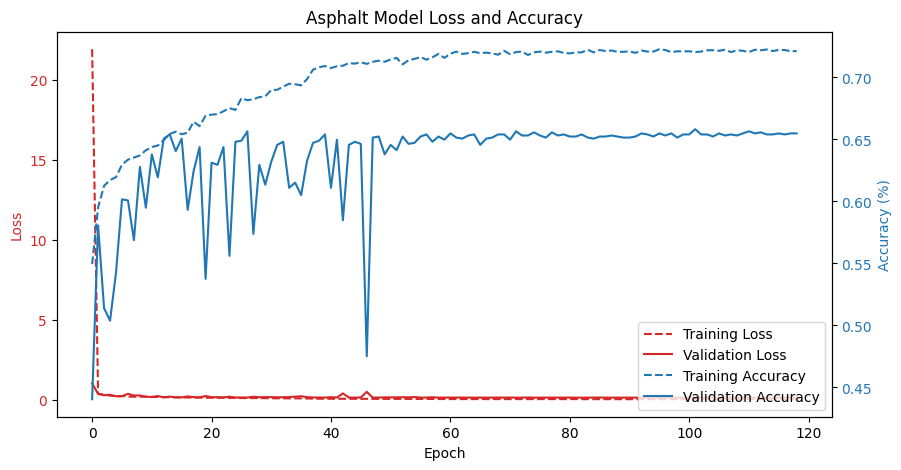

In [67]:
plot_model_performance(history_asphalt, title='Asphalt Model Loss and Accuracy')

### Desert

In [ ]:
plot_model_performance(history_desert, title='Desert Model Loss and Accuracy')

### Offroad

In [ ]:
plot_model_performance(history_offroad, title='Offroad Model Loss and Accuracy')

## Save the Model

### Asphalt

In [56]:
cnn_asphalt.save('trained_model_asphalt_3.h5')

### Desert

In [ ]:
cnn_desert.save('trained_model_desert.h5')

### Offroad

In [ ]:
cnn_offroad.save('trained_model_offroad.h5')

## Perform Integer Quantization on the Model

### Asphalt

In [17]:
# Load the asphalt model
model_name_asphalt = 'trained_model_asphalt.h5'
model_asphalt = load_model(model_name_asphalt)

# Prepare the TensorFlow Lite converter for weight quantization
converter_asphalt = tf.lite.TFLiteConverter.from_keras_model(model_asphalt)
converter_asphalt.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_asphalt = converter_asphalt.convert()

# Save the quantized model
quantized_model_name_asphalt = model_name_asphalt.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_asphalt, 'wb') as f:
    f.write(tflite_quantized_model_asphalt)

print(f"Weight-quantized model saved as {quantized_model_name_asphalt}")

INFO:tensorflow:Assets written to: /tmp/tmpwyesqxcq/assets


INFO:tensorflow:Assets written to: /tmp/tmpwyesqxcq/assets


Weight-quantized model saved as trained_model_asphalt_weight_quantized.tflite


2024-04-08 16:01:37.780040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-08 16:01:37.780055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-08 16:01:37.780457: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpwyesqxcq
2024-04-08 16:01:37.782414: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-04-08 16:01:37.782427: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpwyesqxcq
2024-04-08 16:01:37.788290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-04-08 16:01:37.789866: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-04-08 16:01:37.872198: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpwyesqxcq
2024-04

### Desert

In [ ]:
# Load the desert model
model_name_desert = 'trained_model_desert.h5'
model_desert = load_model(model_name_desert)

# Prepare the TensorFlow Lite converter for weight quantization
converter_desert = tf.lite.TFLiteConverter.from_keras_model(model_desert)
converter_desert.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_desert = converter_desert.convert()

# Save the quantized model
quantized_model_name_desert = model_name_desert.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_desert, 'wb') as f:
    f.write(tflite_quantized_model_desert)

print(f"Weight-quantized model saved as {quantized_model_name_desert}")

### Offroad

In [ ]:
# Load the offroad model
model_name_offroad = 'trained_model_offroad.h5'
model_offroad = load_model(model_name_offroad)

# Prepare the TensorFlow Lite converter for weight quantization
converter_offroad = tf.lite.TFLiteConverter.from_keras_model(model_offroad)
converter_offroad.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model_offroad = converter_offroad.convert()

# Save the quantized model
quantized_model_name_offroad = model_name_offroad.replace('.h5', '_weight_quantized.tflite')
with open(quantized_model_name_offroad, 'wb') as f:
    f.write(tflite_quantized_model_offroad)

print(f"Weight-quantized model saved as {quantized_model_name_offroad}")